In [113]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Load data from CSV files
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')

In [115]:
customers_df.isnull().sum(), transactions_df.isnull().sum(), products_df.isnull().sum()

customers_df.dropna(inplace=True)
transactions_df.dropna(inplace=True)
products_df.dropna(inplace=True)

In [116]:
# Calculate total spend per customer
total_spent = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spent.columns = ['CustomerID', 'TotalSpend']

# Calculate frequency of transactions per customer
transaction_frequency = transactions_df.groupby('CustomerID')['TransactionID'].count().reset_index()
transaction_frequency.columns = ['CustomerID', 'TransactionFrequency']

# Calculate average transaction value
avg_transaction_value = transactions_df.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.columns = ['CustomerID', 'AvgTransactionValue']

In [117]:
customer_features = pd.merge(customers_df, total_spent, on='CustomerID', how='left')
customer_features = pd.merge(customer_features, transaction_frequency, on='CustomerID', how='left')
customer_features = pd.merge(customer_features, avg_transaction_value, on='CustomerID', how='left')

In [119]:
customer_features['LogTotalSpend'] = np.log1p(customer_features['TotalSpend'])

In [120]:
customer_features.head()

,CustomerID,CustomerName,Region,SignupDate,TotalSpend,TransactionFrequency,AvgTransactionValue,LogTotalSpend
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,670.904,8.118362
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,465.685,7.530341
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,681.345,7.910730
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,669.360,8.585950
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,678.080,7.618369


In [121]:
customer_features.isnull().sum()

CustomerID              0
CustomerName            0
Region                  0
SignupDate              0
TotalSpend              1
TransactionFrequency    1
AvgTransactionValue     1
LogTotalSpend           1
dtype: int64

In [122]:
# Fill missing values with the mean of each column
customer_features[['TotalSpend', 'TransactionFrequency', 'AvgTransactionValue']] = customer_features[['TotalSpend', 'TransactionFrequency', 'AvgTransactionValue']].fillna(customer_features[['TotalSpend', 'TransactionFrequency', 'AvgTransactionValue']].mean())


In [123]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalSpend', 'TransactionFrequency', 'AvgTransactionValue']])


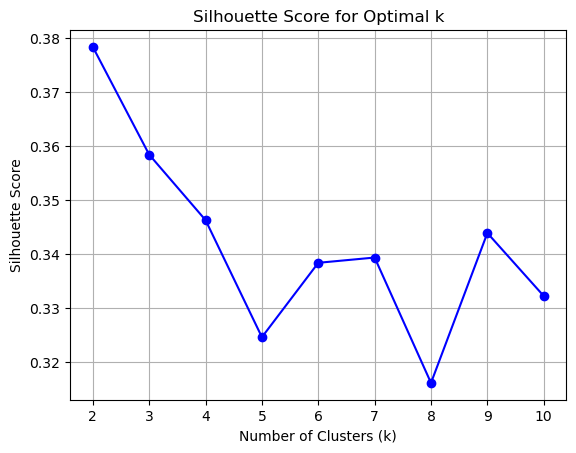

Best number of clusters (k): 2
Silhouette Score for best k: 0.37839163551154414


In [124]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Silhouette Scores for different k values
plt.plot(range(2, 11), silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Best k based on highest Silhouette Score
best_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Best number of clusters (k): {best_k}")
print(f"Silhouette Score for best k: {max(silhouette_scores)}")

In [140]:
# Fit KMeans with the chosen number of clusters (k=4)
kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=42)

customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

customer_features.head()


,CustomerID,CustomerName,Region,SignupDate,TotalSpend,TransactionFrequency,AvgTransactionValue,LogTotalSpend,Cluster,PCA1,PCA2
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,670.904,8.118362,1,-0.079144,-0.050686
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,465.685,7.530341,1,-1.276232,-0.493286
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,681.345,7.910730,1,-0.568677,0.249896
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,669.360,8.585950,0,1.484774,-0.849784
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,678.080,7.618369,1,-1.105944,0.503279


In [141]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute Silhouette Score (only for non-noise points)
silhouette = silhouette_score(scaled_features, customer_features['Cluster'])
print("Silhouette Score:", silhouette)

# Compute DB Index
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print("DB Index:", db_index)


Silhouette Score: 0.37839163551154414
DB Index: 1.0108080055491857


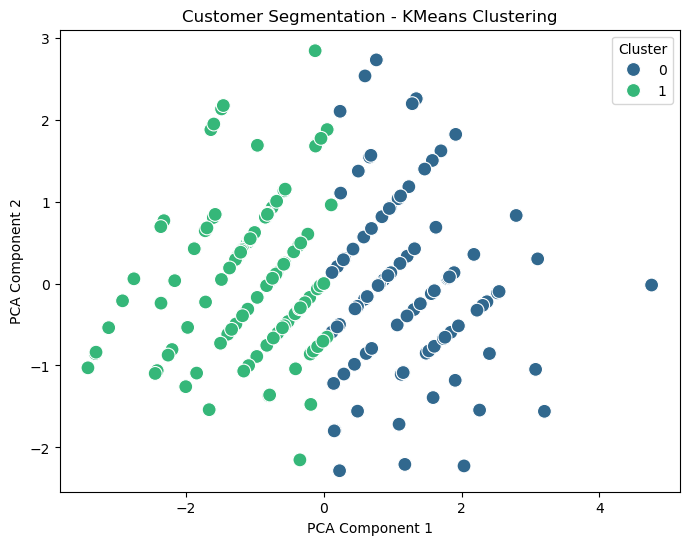

In [127]:
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Add PCA components to the dataframe for plotting
customer_features['PCA1'] = pca_components[:, 0]
customer_features['PCA2'] = pca_components[:, 1]

# Visualize the clusters using PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
plt.title('Customer Segmentation - KMeans Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()
